In [2]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
try:
    stop_words = set(stopwords.words("english"))
except LookupError:
    print("NLTK 'stopwords' ve 'wordnet' paketleri indiriliyor...")
    nltk.download("stopwords", quiet=True)
    nltk.download("wordnet", quiet=True)
    nltk.download('omw-1.4', quiet=True)
    stop_words = set(stopwords.words("english"))

In [4]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

def flatten_jsonl_data(file_path):
    """
    Konuşma bazlı JSONL dosyasını okur, boş satırları atlar ve 
    mesaj bazlı bir DataFrame'e dönüştürür.
    """
    print(f"{os.path.basename(file_path)} dosyası işleniyor...")
    
    all_messages = []
    
    # Dosyayı satır satır aç ve oku
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Satırın başındaki/sonundaki boşlukları temizle
            line = line.strip()
            
            # Eğer satır boşsa (dosya sonundaki boş satır gibi), bu satırı atla
            if not line:
                continue
            
            # Satırı bir JSON objesi olarak yükle
            row = json.loads(line)
            
            # Şimdi bu 'row' objesi (konuşma) üzerinden döngüye gir
            # (Burada sendeki 'iterrows' ve 'messages' hatalarını da düzelttim)
            for i in range(len(row["messages"])):
                message_data = {
                    'game_id': row['game_id'],
                    'speaker': row['speakers'][i],
                    'receiver': row['receivers'][i],
                    'message_text': row['messages'][i],
                    'sender_intention': row['sender_labels'][i],
                    'game_score': row['game_score'][i],
                    'game_score_delta': row['game_score_delta'][i],
                    'year': row['years'][i],
                    'season': row['seasons'][i],
                    'original_fold': row.get('acl2020_fold', os.path.basename(file_path).split('.')[0])
                }
                all_messages.append(message_data)
                
    return pd.DataFrame(all_messages)
            

In [11]:
base_project_path = os.path.dirname(os.getcwd())
data_folder_path = os.path.join(base_project_path, "data", "raw", "2020_acl_diplomacy", "data")
train_path = os.path.join(data_folder_path, "train.jsonl")
val_path = os.path.join(data_folder_path, "validation.jsonl")
test_path = os.path.join(data_folder_path, "test.jsonl")

In [12]:
OUTPUT_DIR = os.path.join(base_project_path, "data", "processed")
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_FILE_PATH = os.path.join(OUTPUT_DIR, "diplomacy_eda_processed.parquet")

In [13]:
if os.path.exists(OUTPUT_FILE_PATH):
    # Eğer dosya varsa, ağır işi atla ve dosyayı doğrudan yükle
    print(f"✅ İşlenmiş EDA dosyası zaten mevcut: '{OUTPUT_FILE_PATH}'")
    print("Doğrudan diskten yükleniyor...")
    start_time = time.time()
    df_eda = pd.read_parquet(OUTPUT_FILE_PATH)
    print(f"Yükleme {time.time() - start_time:.2f} saniyede tamamlandı.")
    
else:
    # Eğer dosya yoksa, tüm ağır işi yap
    print(f"❌ İşlenmiş dosya bulunamadı. Veri işleme süreci başlatılıyor...")
    
    # --- 3a. Yükle ve Düzleştir ---
    df_train = flatten_jsonl_data(train_path)
    df_val = flatten_jsonl_data(val_path)
    df_test = flatten_jsonl_data(test_path)

    # --- 3b. Birleştir ---
    df_eda = pd.concat([df_train, df_val, df_test], ignore_index=True)
    print("\nTüm veri setleri EDA için birleştirildi.")
    print(f"Toplam mesaj (satır) sayısı: {len(df_eda)}")

    # --- 3c. Temizlik ve Özellik Mühendisliği ---
    print("Veri temizleme ve özellik mühendisliği başlıyor...")
    df_eda['target'] = df_eda['sender_intention'].apply(lambda x: 1 if x == False else 0)
    df_eda['cleaned_text'] = df_eda['message_text'].apply(clean_text)
    numeric_cols = ['game_score', 'game_score_delta', 'year']
    for col in numeric_cols:
        df_eda[col] = pd.to_numeric(df_eda[col], errors='coerce')
    df_eda.fillna(0, inplace=True)
    df_eda['message_length'] = df_eda['message_text'].apply(len)
    print("Temizlik tamamlandı.")

    # --- 3d. Kaydet ---
    df_eda.to_parquet(OUTPUT_FILE_PATH, index=False)
    print(f"✅ Tüm EDA verisi '{OUTPUT_FILE_PATH}' olarak kaydedildi.")

# --- 4. ADIM: SON KONTROL ---
print("\nİşlem tamamlandı. DataFrame Bilgisi:")
print(df_eda.info())
print("\nVerinin ilk 5 satırı:")
print(df_eda.head())

❌ İşlenmiş dosya bulunamadı. Veri işleme süreci başlatılıyor...
train.jsonl dosyası işleniyor...
validation.jsonl dosyası işleniyor...
test.jsonl dosyası işleniyor...

Tüm veri setleri EDA için birleştirildi.
Toplam mesaj (satır) sayısı: 17289
Veri temizleme ve özellik mühendisliği başlıyor...
Temizlik tamamlandı.
✅ Tüm EDA verisi 'c:\work environment\Projects\amazon-spam-review\data\processed\diplomacy_eda_processed.parquet' olarak kaydedildi.

İşlem tamamlandı. DataFrame Bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17289 entries, 0 to 17288
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   game_id           17289 non-null  int64 
 1   speaker           17289 non-null  object
 2   receiver          17289 non-null  object
 3   message_text      17289 non-null  object
 4   sender_intention  17289 non-null  bool  
 5   game_score        17289 non-null  int64 
 6   game_score_delta  17289 non-nul

In [14]:
base_path = os.path.dirname(os.getcwd())
data_path = os.path.join(base_path, "data", "raw", "2020_acl_diplomacy", "data", "processed", "diplomacy_eda_processed.parquet")
reports_dir = os.path.join(base_path, "reports", "figures")
os.makedirs(reports_dir, exist_ok=True)

In [15]:
try:
    data = pd.read_parquet(data_path)
    print(f"'{data_path}' dosyasından {len(data)} satır veri başarıyla yüklendi.")
    print(f"Grafikler '{reports_dir}' klasörüne kaydedilecek.")
    # Grafik stilini ayarla
    sns.set_theme(style="whitegrid")
except FileNotFoundError:
    print(f"HATA: '{data_path}' dosyası bulunamadı!")
    print("Lütfen bir önceki ön işleme (preprocessing) kodunu çalıştırdığından emin ol.")

'c:\work environment\Projects\amazon-spam-review\data\raw\2020_acl_diplomacy\data\processed\diplomacy_eda_processed.parquet' dosyasından 17289 satır veri başarıyla yüklendi.
Grafikler 'c:\work environment\Projects\amazon-spam-review\reports\figures' klasörüne kaydedilecek.


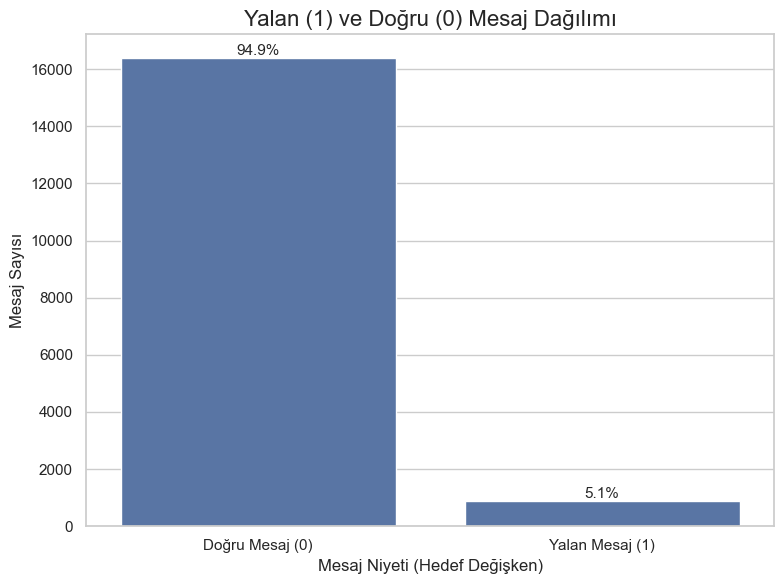

In [17]:
plt.figure(figsize=(8, 6))
# 'class' yerine 'target' kolonunu kullanıyoruz
# HATA DÜZELTME: palette={...} parametresi kaldırıldı.
ax1 = sns.countplot(x='target', data=data) 
plt.title('Yalan (1) ve Doğru (0) Mesaj Dağılımı', fontsize=16)
plt.xlabel('Mesaj Niyeti (Hedef Değişken)', fontsize=12)
plt.ylabel('Mesaj Sayısı', fontsize=12)
# Etiketleri güncelliyoruz
plt.xticks(ticks=[0, 1], labels=['Doğru Mesaj (0)', 'Yalan Mesaj (1)'])

# Yüzdeleri ekle
total = len(data)
for p in ax1.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 100
    ax1.annotate(percentage, (x, y), ha='center', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(reports_dir, "diplomacy_01_class_distribution.png"))
plt.show()

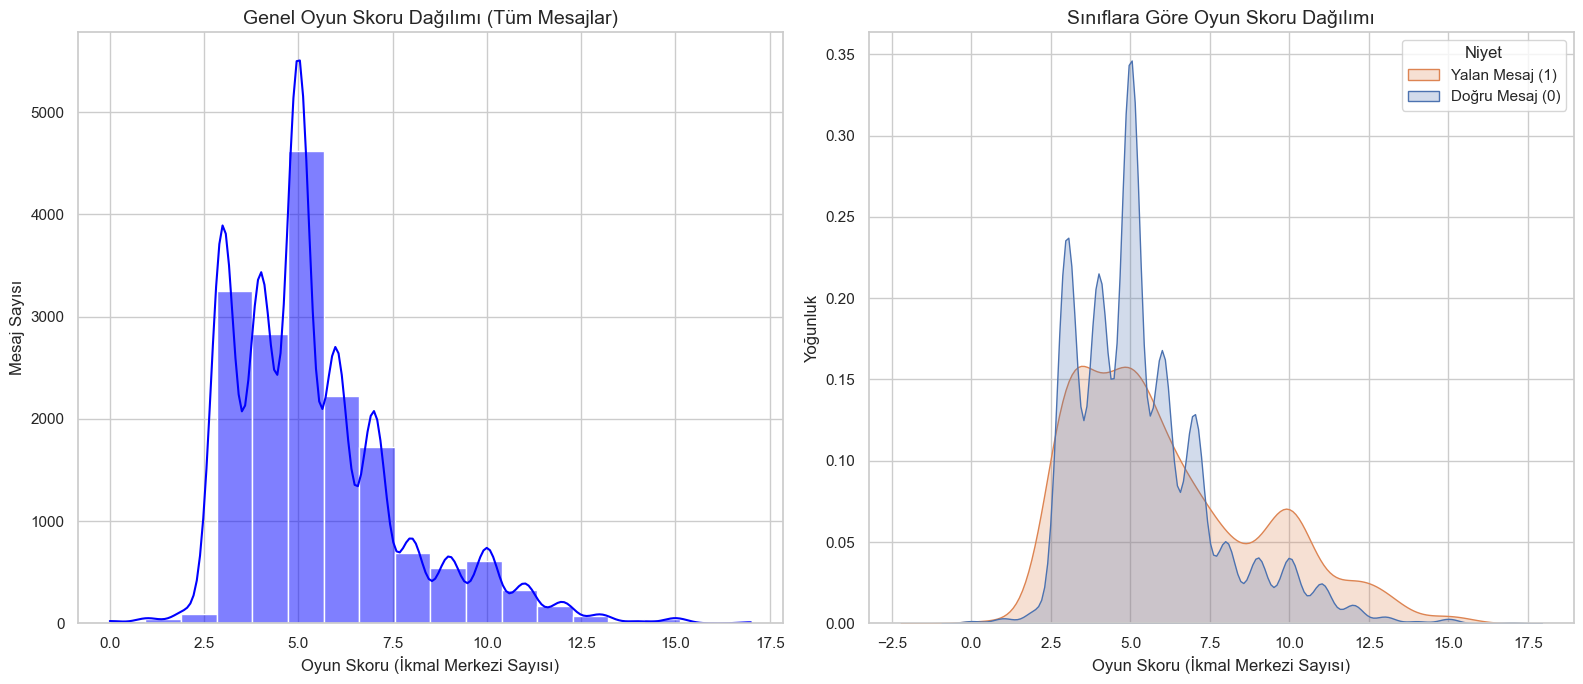

In [18]:
plt.figure(figsize=(16, 7))

# Tüm veri için oyun skoru dağılımı
plt.subplot(1, 2, 1)  
sns.histplot(data=data, x='game_score', bins=18, kde=True, color='blue')
plt.title('Genel Oyun Skoru Dağılımı (Tüm Mesajlar)', fontsize=14)
plt.xlabel('Oyun Skoru (İkmal Merkezi Sayısı)', fontsize=12)
plt.ylabel('Mesaj Sayısı', fontsize=12)

# Sınıflara göre oyun skoru dağılımı
plt.subplot(1, 2, 2)
# HATA DÜZELTME: palette={...} parametresi kaldırıldı.
sns.kdeplot(data=data, x='game_score', hue='target', 
            fill=True, common_norm=False) 
plt.title('Sınıflara Göre Oyun Skoru Dağılımı', fontsize=14)
plt.xlabel('Oyun Skoru (İkmal Merkezi Sayısı)', fontsize=12)
plt.ylabel('Yoğunluk', fontsize=12)
plt.legend(title='Niyet', labels=['Yalan Mesaj (1)', 'Doğru Mesaj (0)'])

plt.tight_layout()
plt.savefig(os.path.join(reports_dir, "diplomacy_02_score_distribution.png"))
plt.show()

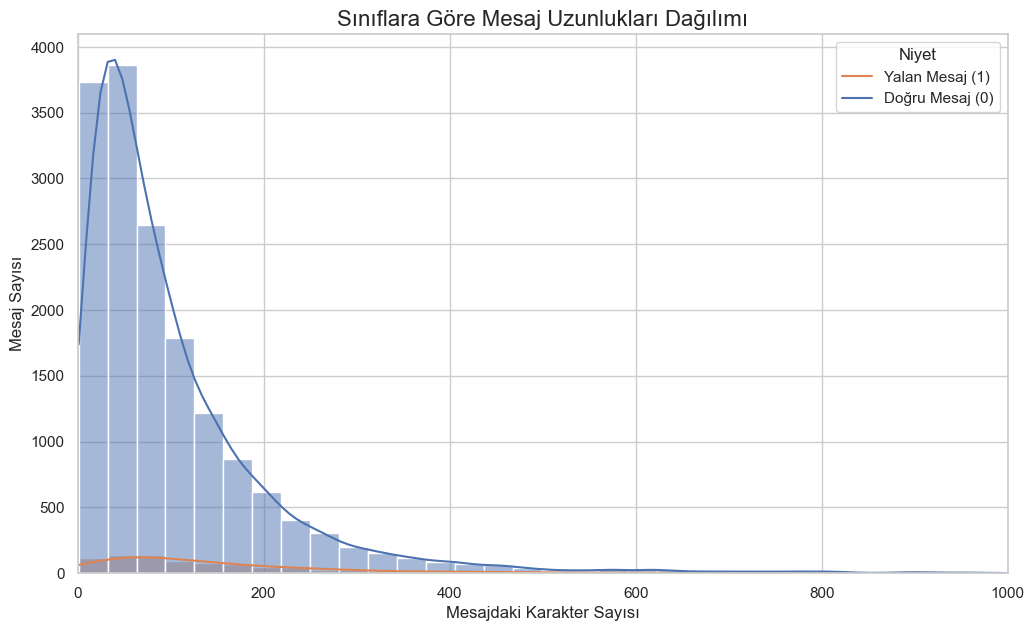

In [19]:
plt.figure(figsize=(12, 7))
# HATA DÜZELTME: palette={...} parametresi kaldırıldı.
sns.histplot(data=data, x='message_length', hue='target', 
             bins=50, kde=True, common_norm=False)
plt.title('Sınıflara Göre Mesaj Uzunlukları Dağılımı', fontsize=16)
plt.xlabel('Mesajdaki Karakter Sayısı', fontsize=12)
plt.ylabel('Mesaj Sayısı', fontsize=12)

plt.xlim(0, 1000) 
plt.legend(title='Niyet', labels=['Yalan Mesaj (1)', 'Doğru Mesaj (0)'])
plt.savefig(os.path.join(reports_dir, "diplomacy_03_length_distribution.png"))
plt.show()

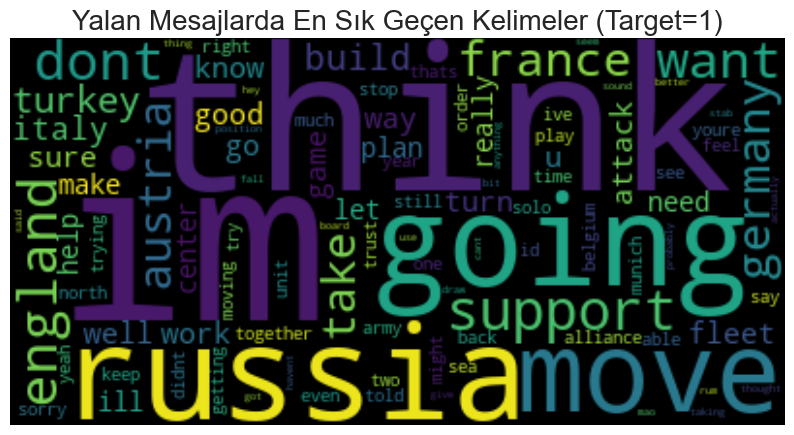

In [ ]:
spam_text = " ".join(review for review in data[data['target'] == 1]['cleaned_text'] if review)

if spam_text:
    plt.figure(figsize=(10, 7))
    wordcloud_spam = WordCloud(max_words=100, background_color="black", collocations=False).generate(spam_text)
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis("off")
    plt.title("Yalan Mesajlarda En Sık Geçen Kelimeler (Target=1)", fontsize=20)
    plt.savefig(os.path.join(reports_dir, "diplomacy_04_wordcloud_lie.png"))
    plt.show()
else:
    print("Yalan mesajlar için kelime bulutu oluşturulacak metin bulunamadı.")

In [ ]:
real_text = " ".join(review for review in data[data['target'] == 0]['cleaned_text'] if review)

if real_text:
    plt.figure(figsize=(10, 7))
    wordcloud_real = WordCloud(max_words=100, background_color="white", collocations=False).generate(real_text)
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.axis("off")
    plt.title("Doğru Mesajlarda En Sık Geçen Kelimeler (Target=0)", fontsize=20)
    plt.savefig(os.path.join(reports_dir, "diplomacy_04_wordcloud_truth.png"))
    plt.show()
else:
    print("Doğru mesajlar için kelime bulutu oluşturulacak metin bulunamadı.")